In [1]:
import pandas as pd
import os

# Define the path to the directory with the CSV files
input_dir = 'processed_results'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Initialize an empty list to hold the DataFrames
dfs = []

# Loop over all CSV files
for file_name in csv_files:
    # Define the file path
    file_path = os.path.join(input_dir, file_name)
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [2]:
#df = pd.read_csv('E:\\Projects\\Unfinished\\Insulin Project\\results2\\adolescent#001_processed.csv')
df.drop(['Time', 'Date'], axis=1, inplace=True)
df.dropna(inplace=True)
df

,CGM,insulin,Meal,Prediction
0,161.643949,0.013117,0,157.432022
1,157.432022,0.013117,0,155.089373
2,155.089373,0.013117,0,153.322710
3,153.322710,0.013117,0,151.958950
4,151.958950,0.013117,0,150.825014
...,...,...,...,...
14424,141.693157,0.013117,0,140.700577
14425,140.700577,0.013117,0,139.741977
14426,139.741977,0.013117,0,138.943963
14427,138.943963,0.013117,0,138.415138


In [3]:
from sklearn.decomposition import PCA
from joblib import dump

# Assume df is your DataFrame and 'feature1', 'feature2' are your columns

# Prepare the features
X = df[['CGM', 'Meal']]

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

dump(pca, 'pca_model.joblib')

# Create a new DataFrame with the PCA components
df_pca = df.copy()
df_pca['PCA1'] = X_pca[:, 0]
df_pca['PCA2'] = X_pca[:, 1]

# Print the DataFrame with the PCA components
print(df_pca)

              CGM   insulin  Meal  Prediction       PCA1      PCA2
0      161.643949  0.013117     0  157.432022   6.448911 -0.598318
1      157.432022  0.013117     0  155.089373   2.237061 -0.623916
2      155.089373  0.013117     0  153.322710  -0.105544 -0.638153
3      153.322710  0.013117     0  151.958950  -1.872176 -0.648890
4      151.958950  0.013117     0  150.825014  -3.235910 -0.657178
...           ...       ...   ...         ...        ...       ...
14424  141.693157  0.013117     0  140.700577 -13.501513 -0.719568
14425  140.700577  0.013117     0  139.741977 -14.494075 -0.725601
14426  139.741977  0.013117     0  138.943963 -15.452657 -0.731426
14427  138.943963  0.013117     0  138.415138 -16.250657 -0.736276
14428  138.415138  0.013117     0  138.155350 -16.779472 -0.739490

[14400 rows x 6 columns]


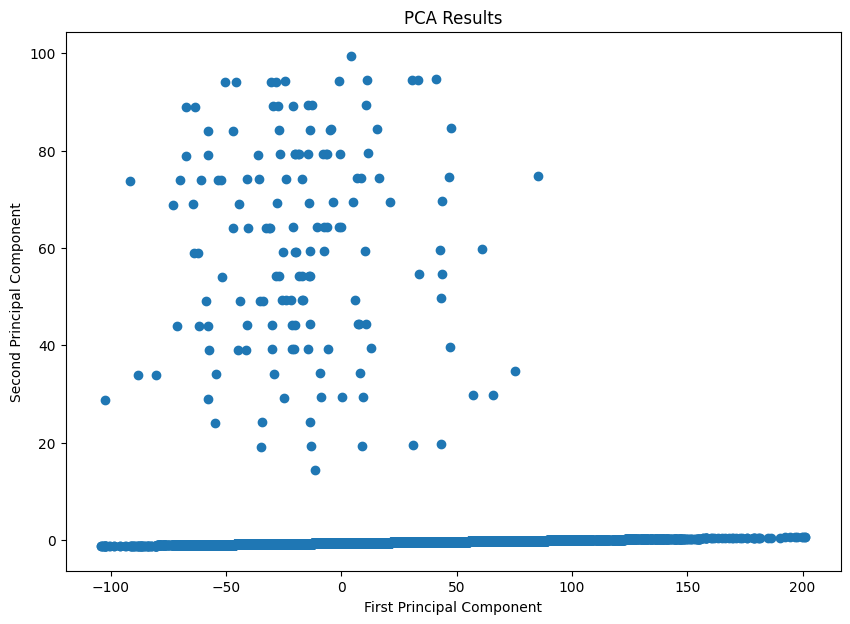

In [4]:
import matplotlib.pyplot as plt

# Assume X_pca is the result of your PCA

# Create a scatter plot of the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1])

# Add labels and title
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Results')

# Show the plot
plt.show()

In [5]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale the 'insulin' column by multiplying by 1000
df_pca['insulin'] = df_pca['insulin'] * 1000

# Define the input features and the target variable
X = df_pca[['CGM', 'Meal', 'PCA1', 'PCA2']].values
y = df_pca[['insulin']].values

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Convert the data into PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)


In [8]:
import torch
from torch import nn

class PrescriptiveModel(nn.Module):
  def __init__(self, input_size):
    super(PrescriptiveModel, self).__init__()
    self.linear1 = nn.Linear(input_size, 20)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(20, 50)
    self.relu = nn.ReLU()
    self.linear3 = nn.Linear(50, 90)
    self.relu = nn.ReLU()
    self.linear4 = nn.Linear(90, 30)
    self.relu = nn.ReLU()
    self.linear5 = nn.Linear(30, 10)
    self.relu = nn.ReLU()
    self.linear6 = nn.Linear(10, 1)
    self.relu = nn.ReLU()
    

  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.relu(self.linear3(x))
    x = self.relu(self.linear4(x))
    x = self.relu(self.linear5(x))
    x = self.relu(self.linear6(x))
    return x


In [9]:
def penalty_function(predicted_dose, acceptable_range, penalty_weight):
  deviation = torch.abs(predicted_dose - (acceptable_range[0] + acceptable_range[1]) / 2)
  penalty = deviation * penalty_weight
  return penalty


In [10]:
def total_loss(predicted_dose, actual_dose, acceptable_range, penalty_weight):
  # MAE loss
  mae_loss = nn.L1Loss()(predicted_dose, actual_dose)
  # Calculate penalty
  penalty = penalty_function(predicted_dose, acceptable_range, penalty_weight)
  # Combine loss and penalty
  total_loss = mae_loss + penalty_weight * penalty
  print(total_loss.shape)
  return total_loss


In [11]:
input_size = X_train.shape[1]  # Get the number of features from tensor shapeprint(input_size)
input_size

4

In [12]:
# Assuming X_train is a tensor
input_shape = X_train.shape[1]  # Get the input shape from training data

# Create the model instance with the correct input size
model = PrescriptiveModel(input_shape)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
penalty_weight = 0.1  # Hyperparameter to tune
acceptable_range = torch.tensor([70, 140])  # Example range in mg/dL

# Load your training data (tensors for features and actual insulin dosage)
num_epochs = 100

for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()
  predicted_dose = model(X_train)
  loss = total_loss(predicted_dose, y_train, acceptable_range, penalty_weight)
  
  # Sum and average the loss
  loss_sum = loss.sum()
  loss_mean = loss.mean()

  print(f"Loss sum: {loss_sum.item()}, Loss mean: {loss_mean.item()}")

  # Backpropagate on the mean loss
  loss_mean.backward()
  optimizer.step()

torch.Size([11520, 1])
Loss sum: 487009.03125, Loss mean: 42.275089263916016
torch.Size([11520, 1])
Loss sum: 480472.25, Loss mean: 41.70766067504883
torch.Size([11520, 1])
Loss sum: 460296.9375, Loss mean: 39.95633316040039
torch.Size([11520, 1])
Loss sum: 424263.0, Loss mean: 36.82838439941406
torch.Size([11520, 1])
Loss sum: 387153.25, Loss mean: 33.607051849365234
torch.Size([11520, 1])
Loss sum: 447611.65625, Loss mean: 38.85517883300781
torch.Size([11520, 1])
Loss sum: 409262.875, Loss mean: 35.52629089355469
torch.Size([11520, 1])
Loss sum: 378810.03125, Loss mean: 32.882816314697266
torch.Size([11520, 1])
Loss sum: 388779.84375, Loss mean: 33.74824905395508
torch.Size([11520, 1])
Loss sum: 399764.09375, Loss mean: 34.701744079589844
torch.Size([11520, 1])
Loss sum: 400704.46875, Loss mean: 34.78337478637695
torch.Size([11520, 1])
Loss sum: 390620.5, Loss mean: 33.90802764892578
torch.Size([11520, 1])
Loss sum: 370630.21875, Loss mean: 32.17276382446289
torch.Size([11520, 1])
Lo

In [13]:
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred_test = model(X_test)
acceptable_range = torch.tensor([70, 140])  # Example range in mg/dL
penalty_weight = 0.4  # Hyperparameter to tune
# Compute the loss on the test set
test_loss = total_loss(y_pred_test, y_test, acceptable_range, penalty_weight)
  # Sum and average the loss
test_loss_sum = loss.sum()
test_loss_mean = loss.mean()
# Print the test loss
print(f'Test Loss: {test_loss_mean.item()}')

torch.Size([2880, 1])
Test Loss: 16.866718292236328


In [14]:
y_pred_test_descaled = y_pred_test/1000
y_test_descaled = y_test/1000
# Print some of the predicted and actual values
for i in range(1000):  # Change this to print more or fewer pairs
    print(f'Predicted: {y_pred_test_descaled[i].item()}, Actual: {y_test_descaled[i].item()}')

Predicted: 0.013250134885311127, Actual: 0.01459166593849659
Predicted: 0.013270004652440548, Actual: 0.01204166654497385
Predicted: 0.013401343487203121, Actual: 0.012941666878759861
Predicted: 0.01326774526387453, Actual: 0.014558332972228527
Predicted: 0.013151656836271286, Actual: 0.010108334012329578
Predicted: 0.014256644062697887, Actual: 0.01204166654497385
Predicted: 0.012788551859557629, Actual: 0.015300000086426735
Predicted: 0.01338133867830038, Actual: 0.00930000003427267
Predicted: 0.013273707590997219, Actual: 0.01080000028014183
Predicted: 0.014197739772498608, Actual: 0.01204166654497385
Predicted: 0.013475906103849411, Actual: 0.013116667047142982
Predicted: 0.013499060645699501, Actual: 0.010108334012329578
Predicted: 0.013030149973928928, Actual: 0.013116667047142982
Predicted: 0.01312127336859703, Actual: 0.01204166654497385
Predicted: 0.01400458998978138, Actual: 0.012941666878759861
Predicted: 0.013167441822588444, Actual: 0.01459166593849659
Predicted: 0.0133645

In [15]:
torch.save(model, 'prescriptive_model.pth')